In [1]:
import os
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla

%matplotlib inline

In [2]:
plt.rcParams["figure.dpi"] = 300

## Problem 1

Recreate Figure 18.4 by performing PCA on the iris dataset, keeping the first two principal components.

In [3]:
iris = datasets.load_iris()
X = iris.data
Y = X - X.mean(axis=0)
U,S,VT = la.svd(Y, full_matrices=False)
S**2/(S**2).sum() # variance percentages

array([ 0.92461621,  0.05301557,  0.01718514,  0.00518309])

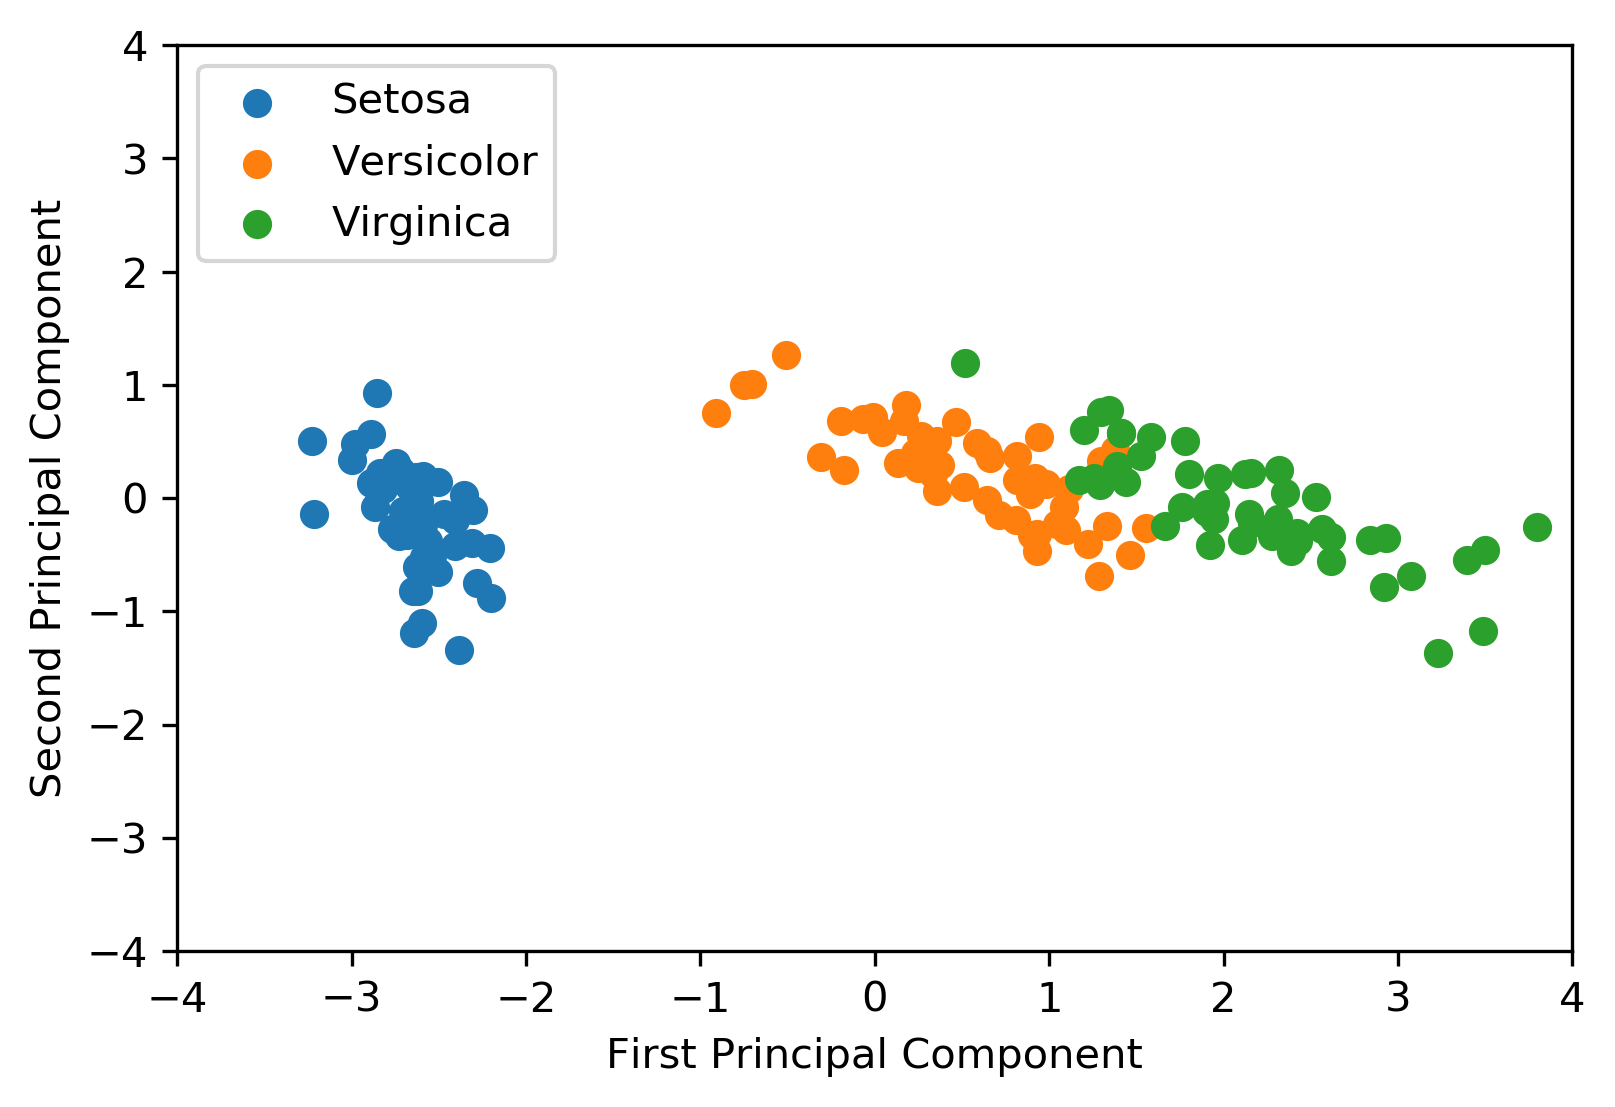

In [4]:
l = 2
Y_hat = np.dot(Y,VT.T[:,:l])
plt.scatter(Y_hat[iris.target==0,0],Y_hat[iris.target==0,1],label='Setosa')
plt.scatter(Y_hat[iris.target==1,0],Y_hat[iris.target==1,1],label='Versicolor')
plt.scatter(Y_hat[iris.target==2,0],Y_hat[iris.target==2,1],label='Virginica')
plt.axis([-4,4,-4,4])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc=2)
plt.show()

## Problem 2

Using the techniques of LSI, applied to the word count matrix $X$, and keeping the first 7 principal components, find the most similar and least similar speeches to both Bill Clinton's 1993 speech and to Ronald Reagan's 1984 speech.

In [5]:
# Get list of filepaths to each text file in the folder.
folder = "./Addresses/"
paths = [folder+p for p in os.listdir(folder) if p[-4:]==".txt"]

# Helper function to get list of words in a string.
def extractWords(text):
    ignore = string.punctuation + string.digits
    cleaned = "".join([t for t in text.strip() if t not in ignore])
    return cleaned.lower().split()

# Initialize vocab set, then read each file and add to the vocab set.
vocab = set()
for p in paths:
    with open(p, 'r') as infile:
        for line in infile:
            vocab.update(extractWords(line))

In [6]:
# load stopwords
with open("stopwords.txt", 'r') as f:
    stops = set([w.strip().lower() for w in f.readlines()])

# remove stopwords from vocabulary, create ordering
vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

In [7]:
counts = []      # holds the entries of X
doc_index = []   # holds the row index of X
word_index = []  # holds the column index of X

# Iterate through the documents.
for doc, p in enumerate(paths):
    with open(p, 'r') as f:
        # Create the word counter.
        ctr = Counter()
        for line in f:
            ctr.update(extractWords(line))
        # Iterate through the word counter, store counts.
        for word, count in ctr.items():
            if word in vocab:
                word_index.append(vocab[word])
                counts.append(count)
                doc_index.append(doc)

# Create sparse matrix holding these word counts.
X = sparse.csr_matrix((counts, [doc_index, word_index]),
                       shape=(len(paths), len(vocab)), dtype=np.float)

In [8]:
def most_least_similar(X) :
    '''
    Find the Presidential address most similar and least similar to Clinton's 1993 and
    Reagan's 1984 State of the Union Addresses.
    
    Input :
        X (nparray) - Bag of words matrix of the speeches (each row one speech)
    '''
    # Do SVD decomposition
    U,S,VT = spla.svds(X,k=7)
    X_hat = X.dot(VT.T)
    # Get ids for needed speeches
    clint_93_id = ['93-Clinton' in paths[i] for i in range(len(paths))].index(True)
    reag_84_id = ['84-Reagan' in paths[i] for i in range(len(paths))].index(True)
    # Get the speeches and represent them as columns, then calculate their norms
    clint_93 = X_hat[clint_93_id,:].T
    clint_norm = np.linalg.norm(clint_93)
    reag_84 = X_hat[reag_84_id,:].T
    reag_norm = np.linalg.norm(reag_84)
    # Initialize difference values and positions
    clint_max_diff = np.inf
    clint_max_diff_pos = clint_93_id
    clint_min_diff = -1
    clint_min_diff_pos = clint_93_id
    reag_max_diff = np.inf
    reag_max_diff_pos = reag_84_id
    reag_min_diff = -1
    reag_min_diff_pos = reag_84_id
    # For each speech, calculate difference, then update
    for i in range(X_hat.shape[0]) :
        cur_speech = X_hat[i,:]
        # Don't compare Clinton 93 with itself
        if i != clint_93_id :
            # Get cos(theta)
            cur_clint_diff = cur_speech.dot(clint_93)/(np.linalg.norm(cur_speech)*clint_norm)
            # If most different so far, update values
            if cur_clint_diff < clint_max_diff :
                clint_max_diff = cur_clint_diff
                clint_max_diff_pos = i
            # If most similar so far, update values
            if cur_clint_diff > clint_min_diff :
                clint_min_diff = cur_clint_diff
                clint_min_diff_pos = i
        # Don't compare Reagan 84 with itself
        if i != reag_84_id :
            cur_reag_diff = cur_speech.dot(reag_84)/(np.linalg.norm(cur_speech)*reag_norm)
            # If most different so far, update values
            if cur_reag_diff < reag_max_diff :
                reag_max_diff = cur_reag_diff
                reag_max_diff_pos = i
            # If most similar so far, update values
            if cur_reag_diff > reag_min_diff :
                reag_min_diff = cur_reag_diff
                reag_min_diff_pos = i
    # Get speech names for most similar and most dissimilar
    clint_sim = paths[clint_min_diff_pos][12:-4]
    clint_diss = paths[clint_max_diff_pos][12:-4]
    reag_sim = paths[reag_min_diff_pos][12:-4]
    reag_diss = paths[reag_max_diff_pos][12:-4]
    # Print results
    print('\t\tReagan 1984\tClinton 1993')
    print('Similar    :\t'+str(reag_sim)+'\t'+str(clint_sim))
    print('Dissimilar :\t'+str(reag_diss)+'\t'+str(clint_diss))

In [9]:
most_least_similar(X)

		Reagan 1984	Clinton 1993
Similar    :	1988-Reagan	2010-Obama
Dissimilar :	1946-Truman	1951-Truman


## Problem 3

Repeat Problem 2 using the matrix $A$.
Do your answers seem more reasonable than before?

In [10]:
t = np.zeros(len(vocab))
counts = []
doc_index = []
word_index = []

# get doc-term counts and global term counts
for doc, path in enumerate(paths):
    with open(path, 'r') as f:
        # create the word counter
        ctr = Counter()
        for line in f:
            words = extractWords(line)
            ctr.update(words)
        # iterate through the word counter, store counts
        for word, count in ctr.items():
            if word in vocab:
                word_ind = vocab[word]
                word_index.append(word_ind)
                counts.append(count)
                doc_index.append(doc)
                t[word_ind] += count

# Get global weights.
g = np.ones(len(vocab))
logM = log(len(paths))
for count, word in zip(counts, word_index):
    p = count/float(t[word])
    g[word] += p*log(p+1)/logM

# Get globally weighted counts.
gwcounts = []
for count, word in zip(counts, word_index):
    gwcounts.append(g[word]*log(count+1))

# Create sparse matrix holding these globally weighted word counts
A = sparse.csr_matrix((gwcounts, [doc_index,word_index]),
                      shape=(len(paths), len(vocab)), dtype=np.float)


In [11]:
most_least_similar(A)

		Reagan 1984	Clinton 1993
Similar    :	1985-Reagan	1992-Bush
Dissimilar :	1946-Truman	1946-Truman
